In [23]:
import h5py
import torch
import copy
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from collections import Counter
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, Subset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_curve, auc, confusion_matrix, average_precision_score, classification_report, ConfusionMatrixDisplay, precision_score, recall_score
from torch.optim.lr_scheduler import LambdaLR, StepLR, SequentialLR

## hyperparameters

In [18]:
SEED = 42
DATASETDIR = "./result/dapi_patches_20um_clean_156820.h5"
DEVICE = torch.device("cuda:0")
BATCH_SIZE = 32
NUM_EPOCHS = 25
LR = 1e-3

In [3]:
def set_seeds(seed_value=42, cuda_deterministic=False):
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
    if cuda_deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True

In [4]:
set_seeds(seed_value=42, cuda_deterministic=True)

In [5]:
class HD5Dataset(Dataset):
    def __init__(self, h5_path):
        self.h5_path = h5_path
        self.h5 = h5py.File(h5_path, 'r')
        self.images = self.h5['images'][:]
        self.labels = self.h5['labels'][:]
        print("Labels shape:", self.labels.shape)

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # 图像 shape 为 [1, H, W]
        image = torch.tensor(self.images[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if image.ndim == 2:
            image = image.unsqueeze(0)
        return image, label

In [6]:
def create_balanced_loader(dataset, batch_size=BATCH_SIZE, seed=SEED):
    
    np.random.seed(seed)

    labels = dataset.labels
    if isinstance(labels, torch.Tensor):
        labels = labels.numpy()

    total_size = len(labels)

    # 正负样本分离
    pos_indices = np.where(labels == 1)[0]
    neg_indices = np.where(labels == 0)[0]

    # 对负类下采样，与正类数量一致
    np.random.shuffle(neg_indices)
    neg_indices = neg_indices[:len(pos_indices)]

    # 合并后打乱索引
    balanced_indices = np.concatenate([pos_indices, neg_indices])
    np.random.shuffle(balanced_indices)

    # 分割比例 8:1:1
    total_balanced = len(balanced_indices)
    train_size = int(total_balanced * 0.8)
    valid_size = int((total_balanced - train_size) * 0.5)
    test_size = total_balanced - train_size - valid_size

    train_indices = balanced_indices[:train_size]
    valid_indices = balanced_indices[train_size:train_size + valid_size]
    test_indices = balanced_indices[train_size + valid_size:]

    print(f"Train: {len(train_indices)}, Val: {len(valid_indices)}, Test: {len(test_indices)}")

    # 构建采样器
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(valid_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    # 构建Loader
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=0)
    valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=0)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=0)

    # 统计各个数据集的样本数量
    print(f"Train set positive: {(labels[train_indices] == 1).sum()}, negative: {(labels[train_indices] == 0).sum()}")
    print(f"Val set positive: {(labels[valid_indices] == 1).sum()}, negative: {(labels[valid_indices] == 0).sum()}")
    print(f"Test set positive: {(labels[test_indices] == 1).sum()}, negative: {(labels[test_indices] == 0).sum()}")

    return train_loader, valid_loader, test_loader

In [7]:
## 加载数据集
dataset = HD5Dataset(DATASETDIR)
train_loader, valid_loader, test_loader = create_balanced_loader(dataset, batch_size=BATCH_SIZE)

Labels shape: (100000,)
Train: 2987, Val: 373, Test: 374
Train set positive: 1485, negative: 1502
Val set positive: 185, negative: 188
Test set positive: 197, negative: 177


## Model

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self, input_shape=(1, 92, 92)):  # 修改为你的图像尺寸
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)

        # ===== 动态计算flatten后维度 =====
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            x = self.pool1(F.relu(self.conv1(dummy)))
            x = self.pool2(F.relu(self.conv2(x)))
            flatten_dim = x.view(1, -1).shape[1]  # 自动获取

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(flatten_dim, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [9]:
print(torch.cuda.is_available())

True


## Train

In [38]:
def train_model(model, train_loader, val_loader, epochs=NUM_EPOCHS, lr=LR, save_dir="models", patience=10):
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    best_val_f1 = 0.0
    best_epoch = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    prev_model_path = None
    no_improve_count = 0  

    for epoch in range(epochs):
        model.train()
        train_loss, train_preds, train_labels = 0, [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_acc = accuracy_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds)

        # ---------- Validation ----------
        model.eval()
        val_probs, val_preds, val_labels = [], [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                probs = F.softmax(outputs, dim=1)[:, 1]
                val_probs.extend(probs.cpu().numpy())
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds)
        val_auc = roc_auc_score(val_labels, val_probs)
        val_auprc = average_precision_score(val_labels, val_probs)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | "
              f"Train Acc: {train_acc:.4f}, F1: {train_f1:.4f} | "
              f"Val Acc: {val_acc:.4f}, F1: {val_f1:.4f}, "
              f"AUC: {val_auc:.4f}, AUPRC: {val_auprc:.4f}")

        # 检查是否提升
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_epoch = epoch + 1
            best_model_wts = copy.deepcopy(model.state_dict())
            no_improve_count = 0  # 重置无提升计数

            if prev_model_path and os.path.exists(prev_model_path):
                os.remove(prev_model_path)
            model_path = os.path.join(save_dir, f"best_model_epoch_{best_epoch}_{timestamp}.pt")
            prev_model_path = model_path
            torch.save(best_model_wts, model_path)
            print(f"Best model updated at epoch {best_epoch} | Saved to {model_path}")
        else:
            no_improve_count += 1
            print(f"No improvement for {no_improve_count} epoch(s)")

        if no_improve_count >= patience:
            print(f"Early stopping triggered after {patience} epochs with no improvement.")
            break

    model.load_state_dict(best_model_wts)
    print(f"Loaded best model from epoch {best_epoch} (Val F1: {best_val_f1:.4f})")


## Evaluation

In [40]:
def evaluate_model(model, test_loader):
    model.eval()
    test_preds, test_probs, test_labels = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            test_probs.extend(probs.cpu().numpy())
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_labels = np.array(test_labels)
    test_preds = np.array(test_preds)
    test_probs = np.array(test_probs)

    # 基本指标
    acc = accuracy_score(test_labels, test_preds)
    precision_val = precision_score(test_labels, test_preds, average="binary")
    recall_val = recall_score(test_labels, test_preds, average="binary")
    f1 = f1_score(test_labels, test_preds, average="binary")

    # AUC
    try:
        auc_roc = roc_auc_score(test_labels, test_probs)
    except:
        auc_roc = np.nan

    # AUPRC
    precision_curve, recall_curve, _ = precision_recall_curve(test_labels, test_probs)
    auprc = auc(recall_curve, precision_curve)

    # 输出
    print(f"Test Evaluation:")
    print(f"  - Accuracy : {acc:.4f}")
    print(f"  - Precision: {precision_val:.4f}")
    print(f"  - Recall   : {recall_val:.4f}")
    print(f"  - F1 Score : {f1:.4f}")
    print(f"  - AUC      : {auc_roc:.4f}")
    print(f"  - AUPRC    : {auprc:.4f}")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN()
train_model(model, train_loader, valid_loader, epochs=NUM_EPOCHS, lr=LR)
evaluate_model(model, test_loader)

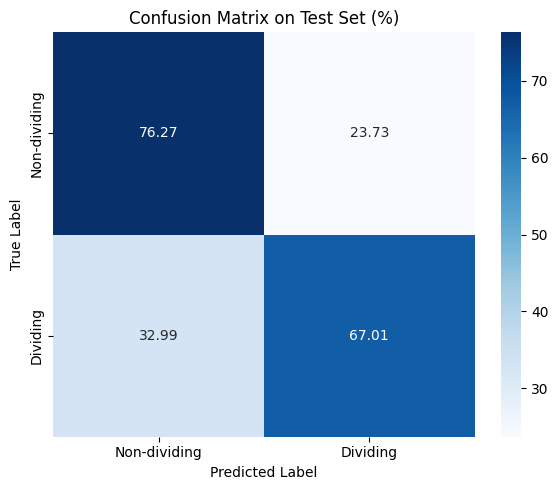

Confusion Matrix (in %):
[[76.27 23.73]
 [32.99 67.01]]

 Evaluation Metrics on Test Set:
  - Accuracy : 0.7139
  - F1 Score : 0.7116
  - ROC AUC  : 0.7675
  - AUPRC    : 0.8063


In [45]:
## 分析最优模型表现
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, 
    f1_score, roc_auc_score, average_precision_score, precision_recall_curve, auc
)

# === 1. 加载模型 ===
best_model_path = "./models/best_model_epoch_3_20250828_110142.pt"
model = SimpleCNN().to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()

# === 2. 预测 ===
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # 概率输出
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_probs.extend(probs)
        all_labels.extend(labels.numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# === 3. 混淆矩阵 ===
cm = confusion_matrix(all_labels, all_preds)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=["Non-dividing", "Dividing"],
            yticklabels=["Non-dividing", "Dividing"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title("Confusion Matrix on Test Set (%)")
plt.tight_layout()
plt.show()

print("Confusion Matrix (in %):")
print(np.round(cm_percent, 2))

# === 4. 指标 ===
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
try:
    auc_roc = roc_auc_score(all_labels, all_probs)
except:
    auc_roc = np.nan

precision, recall, _ = precision_recall_curve(all_labels, all_probs)
auprc = auc(recall, precision)

print(f"\n Evaluation Metrics on Test Set:")
print(f"  - Accuracy : {acc:.4f}")
print(f"  - F1 Score : {f1:.4f}")
print(f"  - ROC AUC  : {auc_roc:.4f}")
print(f"  - AUPRC    : {auprc:.4f}")
